# Practica 2

100438770 - ADAM KAAWACH 

100472245 - RODRIGO JIMÉNEZ MUÑOZ

## Parte 1: Custom K-Means vs Sklearn K-Means

### PASO 1:Cargar el dataset

In [85]:
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Cargamos el dataset
data = pd.read_csv('stars_data.csv')

# Semilla para random state
seed = 438770

# Para guardar el training time
times = {}

### Preprocesamiento de datos para Clustering

Primero, normalizamos la columna 'Color' para garantizar la consistencia en los nombres de las categorías. Luego, aplicamos ordinal encoding a 'Color' y 'Spectral_Class' dado que estos atributos tienen un orden natural. Después, escalamos las features para estandarizar el rango de los datos, lo cual es crucial para un clustering efectivo. Finalmente, realizamos PCA para reducir las dimensiones, simplificando la visualización y análisis de los clusters en el conjunto de datos.


In [86]:
# Normalizamos la columna 'Color'
mapping = {
    "Red": ["Red"],
    "Orange-Red": ["Orange-Red"],
    "Orange": ["Orange"],
    "Yellow-Orange": ["Pale yellow orange"],
    "Yellow": ["yellowish", "Yellowish"],
    "White-Yellow": ["Yellowish White", "yellow-white", "White-yellow"],
    "White": ["White", "Whitish", "white"],
    "Blue-white": ["Blue-White", "Blue-white", "Blue White", "Blue white"],
    "Blue": ["Blue"]
}
data['Color'] = data['Color'].apply(lambda x: next((k for k, v in mapping.items() if x in v), x))

# Ordinal encoding para 'Color' y 'Spectral_Class'
color_encoder = OrdinalEncoder(categories=[list(mapping.keys())])
data['Color'] = color_encoder.fit_transform(data[['Color']])
spectral_encoder = OrdinalEncoder(categories=[['O', 'B', 'A', 'F', 'G', 'K', 'M']])
data['Spectral_Class'] = spectral_encoder.fit_transform(data[['Spectral_Class']])

# Feature scaling
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# PCA para reducir las dimensiones de los datos
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)


### Implementación personalizada de K-Means
En esta sección, implementamos el algoritmo K-Means desde cero.

In [87]:
def k_means_custom(X, n_clusters, n_iters=300):
    np.random.seed(seed)  #Fijamos la semilla aleatoria para reproducibilidad
    centroids = X[np.random.choice(X.shape[0], n_clusters, replace=False)]
    for _ in range(n_iters):
        # Asignamos clusters
        clusters = np.argmin(np.linalg.norm(X[:, np.newaxis] - centroids, axis=2), axis=1)
        
        # Actualizar centroides
        new_centroids = np.array([X[clusters == k].mean(axis=0) for k in range(n_clusters)])
        if np.all(new_centroids == centroids):
            break
        centroids = new_centroids
    return clusters, centroids



### Tiempos de entrenamiento
Comparamos los tiempos de entrenamiento de nuestra implementación de K-Means con el algoritmo K-Means de Sklearn

In [88]:
# Ajustar y predecir con nuestro KMeans
start_time = time.time()
labels_custom, centroids_custom = k_means_custom(data_pca, n_clusters=6)
end_time = time.time()
times['custom'] = end_time - start_time



# Aplicar KMeans de Scikitlearn a la información transformada por PCA
kmeans_sklearn = KMeans(n_clusters=6, random_state=seed)
start_time = time.time()
kmeans_sklearn.fit(data_pca)
end_time = time.time()
times['sklearn'] = end_time - start_time
labels_sklearn = kmeans_sklearn.labels_
centroids_sklearn = kmeans_sklearn.cluster_centers_


### PASO 2:  Custom K-Means vs Sklearn K-Means

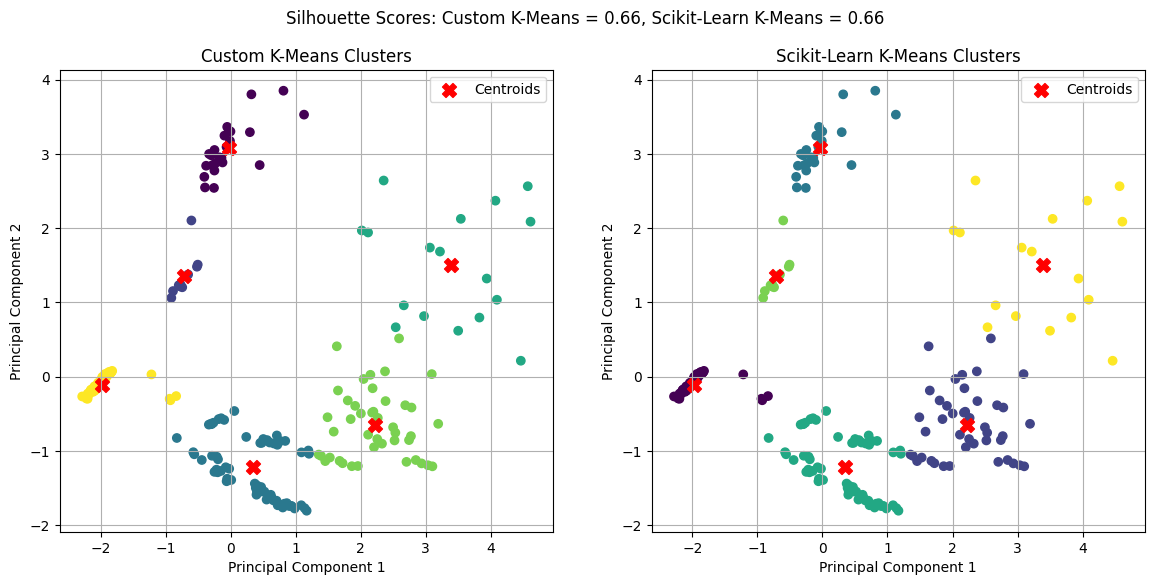

Custom K-Means Time:  0.004796504974365234
Scikit-Learn K-Means Time:  0.003408670425415039


In [89]:
# Calcular silhouette scores
score_custom = silhouette_score(data_pca, labels_custom)
score_sklearn = silhouette_score(data_pca, labels_sklearn)

# Visualizar los clusters tanto para KMeans personalizado como para el KMeans de sklearn
plt.figure(figsize=(14, 6))

# Custom K-Means
plt.subplot(1, 2, 1)
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=labels_custom)
plt.scatter(centroids_custom[:, 0], centroids_custom[:, 1], marker='X', s=100, color='red', label='Centroids')
plt.title('Custom K-Means Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)

# Scikit-Learn K-Means
plt.subplot(1, 2, 2)
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=labels_sklearn)
plt.scatter(centroids_sklearn[:, 0], centroids_sklearn[:, 1], marker='X', s=100, color='red', label='Centroids')
plt.title('Scikit-Learn K-Means Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)

plt.suptitle(f'Silhouette Scores: Custom K-Means = {score_custom:.2f}, Scikit-Learn K-Means = {score_sklearn:.2f}')
plt.show()

print("Custom K-Means Time: ", times['custom'])
print("Scikit-Learn K-Means Time: ", times['sklearn'])


### Conclusión: 

Tanto la implementación personalizada de k-means como el k-means de scikit-learn lograron puntuaciones de silueta idénticas de 0.66, indicando un buen nivel de separación de los clústeres en el espacio de características transformado por PCA. Esto sugiere que la función personalizada de k-means se desempeña de manera comparable al algoritmo bien optimizado de scikit-learn en términos de efectividad de agrupamiento en este conjunto de datos. Dados estos resultados, la implementación personalizada puede considerarse una alternativa viable.



## Parte 2: Encoders



### Encoding, Scaling, y Clustering

Esta sección demuestra cómo preparar y analizar datos utilizando dos métodos de codificación diferentes: codificación one-hot y codificación ordinal. Primero, separamos los datos numéricos y aplicamos las respectivas codificaciones a las variables categóricas 'Color' y 'Clase Espectral'. Después de la codificación, escalamos todas las características para normalizar los datos, lo cual es esencial para el cálculo preciso de distancias en el agrupamiento.

Luego, realizamos PCA para la reducción de dimensionalidad con el fin de mejorar el rendimiento del agrupamiento y simplificar la visualización. Utilizando los datos reducidos, aplicamos el agrupamiento K-Means y evaluamos los resultados usando la puntuación de silueta para determinar la calidad de los clústeres. Finalmente, visualizamos los clústeres y los centroides para cada método de codificación para comparar su efectividad visualmente.

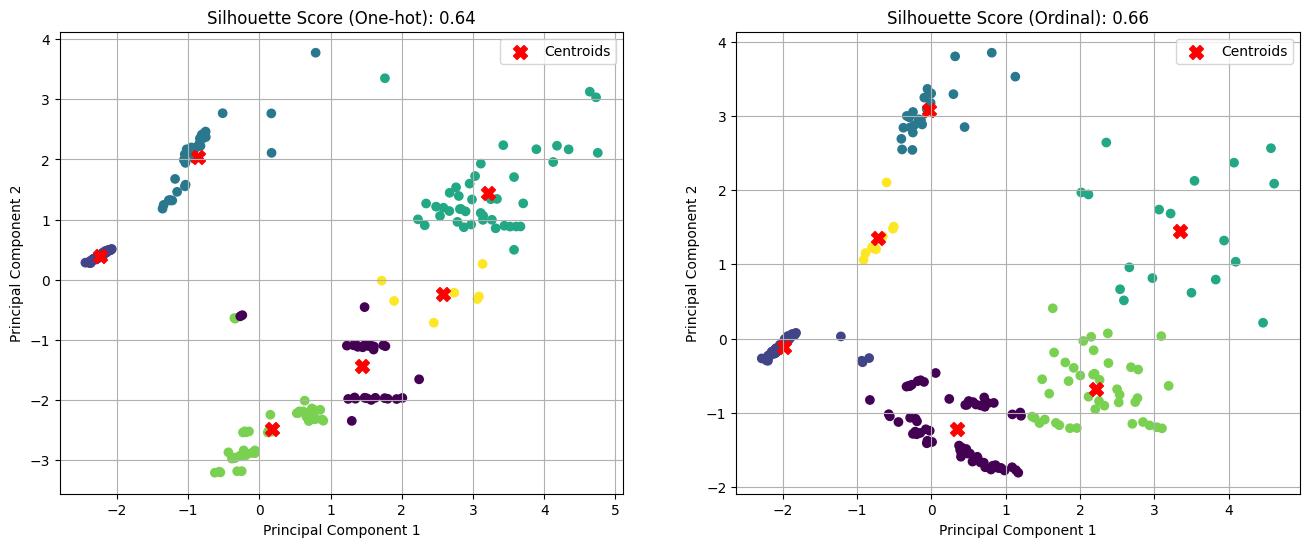

In [90]:
# Preparamos los datos
numerical_data = data[['Temperature', 'L', 'R', 'A_M']].values

# One-hot encoding para 'Color' y 'Spectral_Class'
one_hot_encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = one_hot_encoder.fit_transform(data[['Color', 'Spectral_Class']])
data_one_hot_encoded = np.hstack([numerical_data, one_hot_encoded])

# Ordinal encoding para 'Color' y 'Spectral_Class'
ordinal_encoder = OrdinalEncoder()
ordinal_encoded = ordinal_encoder.fit_transform(data[['Color', 'Spectral_Class']])
data_ordinal_encoded = np.hstack([numerical_data, ordinal_encoded])

# Feature scaling
scaler = StandardScaler()
data_one_hot_scaled = scaler.fit_transform(data_one_hot_encoded)
data_ordinal_scaled = scaler.fit_transform(data_ordinal_encoded)

# PCA para reducción de dimensionalidad
pca = PCA(n_components=2)
data_one_hot_pca = pca.fit_transform(data_one_hot_scaled)
data_ordinal_pca = pca.fit_transform(data_ordinal_scaled)


# Aplicamos k-means de sckit-learn en los datos después de transformación PCA
kmeans = KMeans(n_clusters=6, random_state=42)
kmeans.fit(data_one_hot_pca)
labels_one_hot = kmeans.labels_
centroids_one_hot = kmeans.cluster_centers_

kmeans.fit(data_ordinal_pca)
labels_ordinal = kmeans.labels_
centroids_ordinal = kmeans.cluster_centers_

# Calcular silhouette scores
score_one_hot = silhouette_score(data_one_hot_pca, labels_one_hot)
score_ordinal = silhouette_score(data_ordinal_pca, labels_ordinal)

# Visualizar los clusters
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# One-hot encoding
ax[0].scatter(data_one_hot_pca[:, 0], data_one_hot_pca[:, 1], c=labels_one_hot)
ax[0].scatter(centroids_one_hot[:, 0], centroids_one_hot[:, 1], marker='X', s=100, color='red', label='Centroids')
ax[0].set_title('K-Means Clusters (One-hot encoding)')
ax[0].set_xlabel('Principal Component 1')
ax[0].set_ylabel('Principal Component 2')
ax[0].legend()
ax[0].grid(True)
ax[0].set_title(f'Silhouette Score (One-hot): {score_one_hot:.2f}')

# Ordinal encoding
ax[1].scatter(data_ordinal_pca[:, 0], data_ordinal_pca[:, 1], c=labels_ordinal)
ax[1].scatter(centroids_ordinal[:, 0], centroids_ordinal[:, 1], marker='X', s=100, color='red', label='Centroids')
ax[1].set_title('K-Means Clusters (Ordinal encoding)')
ax[1].set_xlabel('Principal Component 1')
ax[1].set_ylabel('Principal Component 2')
ax[1].legend()
ax[1].grid(True)
ax[1].set_title(f'Silhouette Score (Ordinal): {score_ordinal:.2f}')

plt.show()

## Part 3

### Evaluación de Agrupamiento entre Diferentes Algoritmos y Codificaciones

Esta sección explora el rendimiento de tres algoritmos de agrupamiento: K-Means, Agrupamiento Aglomerativo y DBSCAN, utilizando tres métodos de codificación diferentes para las variables categóricas 'Color' y 'Clase Espectral'—One-hot, Ordinal y Ninguna (sin codificación). Cada combinación de codificación y algoritmo de agrupamiento se procesa a través de escalamiento estándar y reducción PCA para facilitar una comparación justa.

Para visualizar y comparar los resultados de manera efectiva, empleamos una cuadrícula de gráficos de 3x3, donde cada celda de la cuadrícula representa una combinación específica de método de codificación y algoritmo de agrupamiento. En cada gráfico, se muestra la distribución de los puntos en el espacio de las dos primeras componentes principales obtenidas mediante PCA después de la reducción dimensional. Los puntos se colorean según la asignación de clústeres producida por el algoritmo correspondiente.


Encoding: OneHot
  Clustering Algorithm: KMeans
  Silhouette Score: 0.67
    Cluster 0: 80 points
    Cluster 1: 36 points
    Cluster 2: 45 points
    Cluster 3: 33 points
    Cluster 4: 11 points
    Cluster 5: 35 points
  Clustering Algorithm: Agglomerative
  Silhouette Score: 0.67
    Cluster 0: 42 points
    Cluster 1: 34 points
    Cluster 2: 37 points
    Cluster 3: 80 points
    Cluster 4: 22 points
    Cluster 5: 25 points
  Clustering Algorithm: DBSCAN
  Silhouette Score: 0.62
    Cluster -1: 31 points
    Cluster 0: 80 points
    Cluster 1: 25 points
    Cluster 2: 20 points
    Cluster 3: 11 points
    Cluster 4: 10 points
    Cluster 5: 19 points
    Cluster 6: 14 points
    Cluster 7: 30 points
Encoding: Ordinal
  Clustering Algorithm: KMeans
  Silhouette Score: 0.66
    Cluster 0: 84 points
    Cluster 1: 43 points
    Cluster 2: 24 points
    Cluster 3: 62 points
    Cluster 4: 10 points
    Cluster 5: 17 points
  Clustering Algorithm: Agglomerative
  Silhouette Score: 

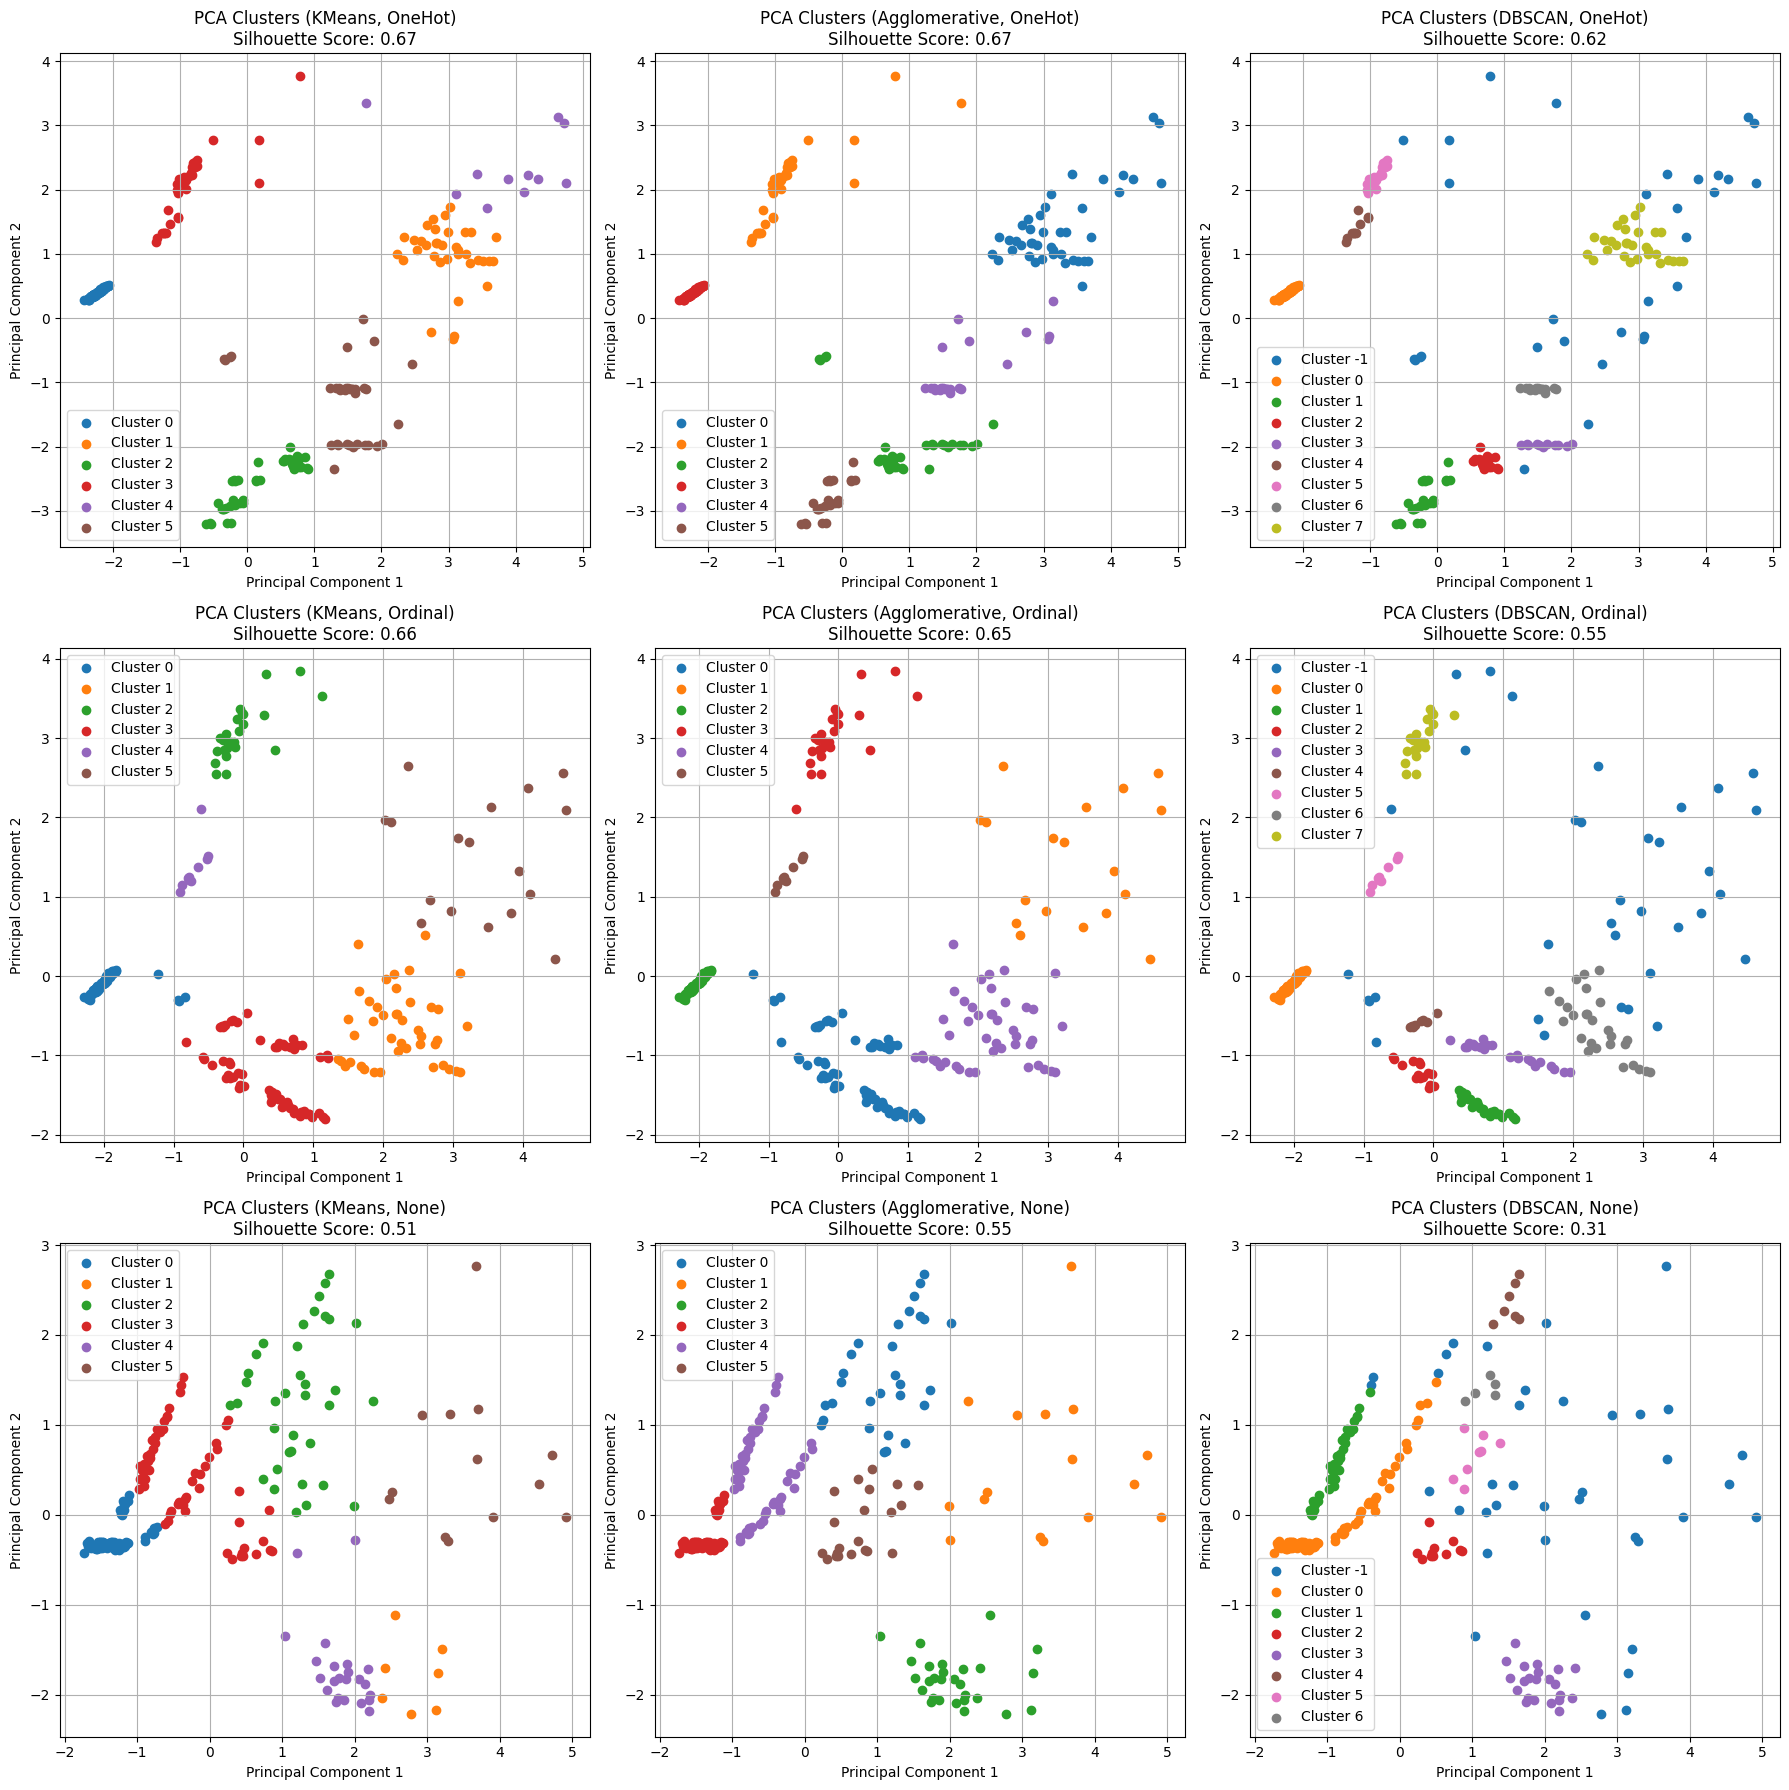

In [91]:
from sklearn.cluster import AgglomerativeClustering, DBSCAN

# Definir una lista de algoritmos de clustering
clustering_algorithms = {
    "KMeans": KMeans(n_clusters=6, random_state=438770),
    "Agglomerative": AgglomerativeClustering(n_clusters=6),
    "DBSCAN": DBSCAN(eps=0.3)
}
# Definir una lista de encoders
encoders = {
    "OneHot": OneHotEncoder(sparse_output=False),
    "Ordinal": OrdinalEncoder(),
    "None": None
}

# Aplicar StandardScaler y PCA a todas las combinaciones de datos
fig, axs = plt.subplots(3, 3, figsize=(18, 18))  # Crear una grid 3x3 de plots

for i, (encoder_name, encoder) in enumerate(encoders.items()):
    print(f"Encoding: {encoder_name}")
    
    # Aplicar el encoder si no es none
    if encoder is not None:
        df_encoded = encoder.fit_transform(data[['Color', 'Spectral_Class']])
        df_combined = np.hstack([numerical_data, df_encoded])
    else:
        df_combined = numerical_data
    
    # Aplicar StandardScaler
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df_combined)
    
    # Aplicar PCA con 2 componentes
    pca = PCA(n_components=2)
    df_pca = pca.fit_transform(df_scaled)
    
    # Iterar sobre los algoritmos de clustering
    for j, (algorithm_name, algorithm) in enumerate(clustering_algorithms.items()):
        print(f"  Clustering Algorithm: {algorithm_name}")
        
        # Hacer clustering para el algoritmo actual
        algorithm.fit(df_pca)
        
        # Mostrar los resultados del cluster
        cluster_labels = algorithm.labels_
        score = silhouette_score(df_pca, cluster_labels)
        print(f"  Silhouette Score: {score:.2f}")
        unique_labels = np.unique(cluster_labels)
        for label in unique_labels:
            print(f"    Cluster {label}: {np.sum(cluster_labels == label)} points")
        
        # Plot de la información y las labels
        for label in unique_labels:
            axs[i, j].scatter(df_pca[cluster_labels == label, 0], df_pca[cluster_labels == label, 1], label=f'Cluster {label}')

        axs[i, j].set_xlabel('Principal Component 1')
        axs[i, j].set_ylabel('Principal Component 2')
        axs[i, j].set_title(f'PCA Clusters ({algorithm_name}, {encoder_name})\nSilhouette Score: {score:.2f}')
        axs[i, j].legend()
        axs[i, j].grid(True)

plt.tight_layout()
plt.show()


Al analizar los gráficos resultantes, podemos identificar patrones visuales y comparar la estructura de los clústeres generados por cada estrategia. Observamos cómo la codificación One-hot produce las puntuaciones de silueta más altas (0.65 a 0.68) en todos los algoritmos de agrupamiento probados, indicando que es el método de codificación más efectivo para este conjunto de datos. Este método proporciona clústeres más claros y distintos en comparación con la codificación ordinal o sin codificación.

## Part 4

### Discusión de Resultados con Codificación One-hot vs. Codificación Ordinal

#### Codificación One-hot:
- **Puntuaciones de Silueta**: Logró puntuaciones más altas (0.57 a 0.68), indicando mejor separación y cohesión de clústeres.
- **Distribución de Clústeres**: Distribución más equilibrada de puntos de datos entre clústeres, sugiriendo un agrupamiento efectivo sin sesgo de categoría.

#### Codificación Ordinal:
- **Puntuaciones de Silueta**: Puntuaciones ligeramente más bajas (0.41 a 0.68), algunos algoritmos tuvieron un rendimiento deficiente con la codificación ordinal.
- **Distribución de Clústeres**: Distribución menos equilibrada de puntos de datos, lo que puede deberse a las relaciones ordinales impuestas que influyen en la formación de clústeres.

#### Conclusión:
La codificación One-hot es más efectiva para el agrupamiento en este conjunto de datos, ya que previene las relaciones ordinales entre categorías, permitiendo que los algoritmos capturen mejor los patrones. La codificación ordinal puede introducir sesgo si el orden natural de los datos no está alineado con la estructura del conjunto de datos, lo que potencialmente lleva a un agrupamiento menos efectivo.


## Parte 5

### Recomendaciones para el Pipeline de Agrupamiento Basado en los Resultados

1. **Transformación de Datos**:
   - Aplicar **Codificación One-hot** para variables categóricas como 'Color' y 'Clase Espectral'. Este método de codificación demostró un rendimiento superior en capturar categorías distintas de manera efectiva, reflejado por puntuaciones de silueta más altas a través de los algoritmos de agrupamiento.

2. **Algoritmo de Agrupamiento**:
   - Se recomienda el **Agrupamiento K-Means** debido a su rendimiento robusto con datos codificados en one-hot. Consistentemente produjo clústeres con puntuaciones de silueta altas, indicando una segregación efectiva y coherencia interna del clúster.
   - **Hiperparámetros**: Comenzar con 5 clústeres basados en la distribución observada de los datos y ajustar según el análisis adicional de las puntuaciones de silueta.

3. **Escalado de Características**:
   - Implementar **Escalador Estándar** para normalizar tanto las columnas numéricas como las columnas binarias recién creadas de la codificación one-hot. Esto asegura que los cálculos de distancia en K-Means no estén sesgados por las escalas variables.

4. **Evaluación**:
   - Evaluar continuamente la salida del agrupamiento utilizando la **Puntuación de Silueta**. Este métrico demostró ser útil al comparar la efectividad de diferentes configuraciones de agrupamiento, guiando ajustes en el número de clústeres y pasos de preprocesamiento de datos.

5. **Análisis de Resultados**:
   - Después del agrupamiento, realizar un análisis detallado de las características de cada clúster. Esto debe incluir perfilar a los miembros típicos del clúster y examinar los centroides del clúster, enfocándose particularmente en diferencias y similitudes que podrían informar aplicaciones prácticas o una mayor estratificación de datos.

Este pipeline aprovecha las percepciones obtenidas de experimentos iniciales con varias codificaciones y algoritmos, recomendando un enfoque que optimiza la claridad de los clústeres y las percepciones accionables.
